# 循环神经元

单个实例的循环层的输出

$y_{(t)}=\phi(W_x^Tx_{(i)}+W_y^Ty_{(t-1)}+b)$

本轮输出等于本轮输入$x_{(i)}$乘以权重$W_x^T$上一轮输出$y_{(t-1)}$乘以权重$W_y^Ty$，加上偏置项$b$，

即👇

$y_{(t)}=\phi([x_{(i)}y_{(t-1)}]W+b)$, 
$W= \left[
   \begin{matrix}
   W_x \\
   W_y \\
  \end{matrix}
   \right]$

   其中
   $[x_{(i)}y_{(t-1)}]$表示水平拼接向量或矩阵，$W$是纵向拼接矩阵

In [1]:
import numpy as np
import keras

In [2]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
# 生成数字序列方法，无需深究
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 *10 + 10)) # 一浪
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # 二浪
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # 噪音
    return series[..., np.newaxis].astype(np.float32) # 注意加一个维度

In [6]:
# 生成10000个序列，每个序列50期（+1期作为y），序列为一维
n_steps = 50
series = generate_time_series(10000, n_steps + 1) 

In [7]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:,-1] 

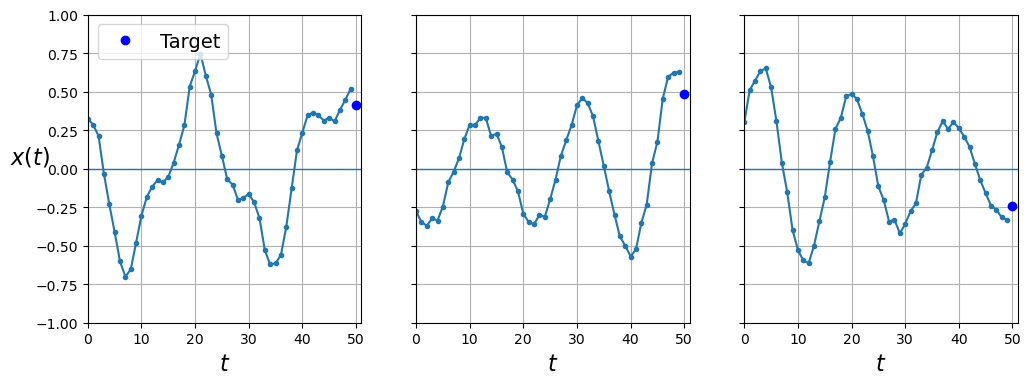

In [8]:
# 画图函数不用深究
import matplotlib.pyplot as plt
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

## 基准指标 baseline

### 指标一 简单方法

In [9]:
y_pred = X_valid[:, -1] # 直接对比序列最后一个值和y的均方差👇
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02196601

In [10]:
X_valid[:, -1]

array([[ 0.51809084],
       [ 0.62986696],
       [-0.33173487],
       ...,
       [ 0.25734296],
       [-0.13468716],
       [-0.03794139]], dtype=float32)

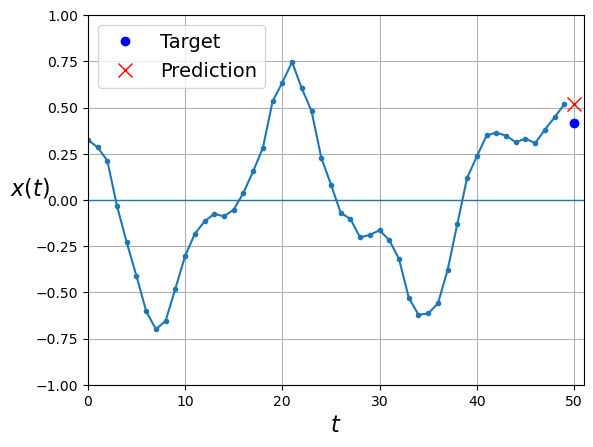

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 指标二 线性模型

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50 ,1]),
    keras.layers.Dense(1)
])

In [13]:
X_train.shape

(7000, 50, 1)

In [14]:
X_train[0,...].shape

(50, 1)

In [15]:
model.compile(loss='mse', optimizer='Adam')

In [16]:
history = model.fit(X_train, y_train, epochs=20 , validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 5ms/step - loss: 0.0529 - val_loss: 0.0266
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0178 - val_loss: 0.0126
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0046

## 简单RNN模型

In [28]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) 
    # RNN可以处理任意长度序列，因此第一个输入维度为None
])

In [29]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 14s 60ms/step - loss: 0.1676 - val_loss: 0.1467
Epoch 2/10
219/219 [==============================] - 12s 57ms/step - loss: 0.1451 - val_loss: 0.1431
Epoch 3/10
219/219 [==============================] - 12s 54ms/step - loss: 0.1440 - val_loss: 0.1431
Epoch 4/10
219/219 [==============================] - 10s 47ms/step - loss: 0.1439 - val_loss: 0.1432
Epoch 5/10
219/219 [==============================] - 11s 48ms/step - loss: 0.1440 - val_loss: 0.1431
Epoch 6/10
219/219 [==============================] - 11s 48ms/step - loss: 0.1440 - val_loss: 0.1431
Epoch 7/10
219/219 [==============================] - 11s 49ms/step - loss: 0.1440 - val_loss: 0.1431
Epoch 8/10
219/219 [==============================] - 11s 48ms/step - loss: 0.1439 - val_loss: 0.1432
Epoch 9/10
219/219 [==============================] - 10s 48ms/step - loss: 0.1440 - val_loss: 0.1432
Epoch 10/10
219/219 [==============================] - 11s 49ms/step - loss: 0.144

loss比简单方法要低，但比线性模型要差

RNN激活函数一般为双曲正切函数tanh，范围是-1到1，S型函数

keras默认仅返回最终输出，若要在某一层返回一个输出，设置参数 `return_sequence = True`

## 深度RNN

In [17]:
model = keras.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # 如果最后一层是SimpleRNN，则需要设置`返回序列`
    keras.layers.Dense(1) # Dense层更快（一倍），也可以用SimpleRNN(1)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.005))
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
219/219 [==============================] - 27s 121ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 2/10
219/219 [==============================] - 26s 119ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 3/10
219/219 [==============================] - 37s 167ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 4/10
219/219 [==============================] - 37s 169ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 5/10
219/219 [==============================] - 36s 164ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 6/10
219/219 [==============================] - 36s 166ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 7/10
219/219 [==============================] - 34s 157ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/10
219/219 [==============================] - 28s 127ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 9/10
219/219 [==============================] - 24s 112ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 10/10
219/219 [==============================] - 24s 110ms/step - l

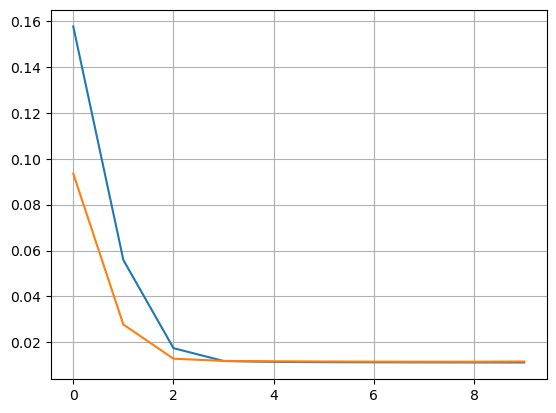

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
plt.grid()
plt.plot(pd.DataFrame(history.history))

## 一次预测未来10步

In [30]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [41]:
Y.shape, series.shape

((10000, 50, 10), (10000, 60, 1))

例如，现在有若干个长度为60的向量，其中每一个向量的每个值都属于一组x，每个值的后面10组值对应该组x的y，那么有50组x，50组y，最后一个x还要对应10组y，因此原数据长度60

可以看出，x和y的数据是有重叠的，但不属于作弊

In [32]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [43]:
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
'''
# 最后也可以是直接Dense(10),如下,但所需要的数据维度不同,而且是用前面所有步长预测最后10个步长
  然而如果用keras.layers.TimeDistributed(),则每一步都用于训练和计算误差
  注：这种方法等于一维卷积
  TimeDistributed(Dense(10)) = Conv1D(n, filter_size=1)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])
'''
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 32s 139ms/step - loss: 0.0465 - last_time_step_mse: 0.0347 - val_loss: 0.0341 - val_last_time_step_mse: 0.0201
Epoch 2/20
219/219 [==============================] - 28s 130ms/step - loss: 0.0341 - last_time_step_mse: 0.0209 - val_loss: 0.0353 - val_last_time_step_mse: 0.0219
Epoch 3/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0299 - last_time_step_mse: 0.0167 - val_loss: 0.0311 - val_last_time_step_mse: 0.0195
Epoch 4/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0267 - last_time_step_mse: 0.0135 - val_loss: 0.0236 - val_last_time_step_mse: 0.0103
Epoch 5/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0240 - last_time_step_mse: 0.0113 - val_loss: 0.0224 - val_last_time_step_mse: 0.0094
Epoch 6/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0224 - last_time_step_mse: 0.0099 - val_loss: 0.0219 - val_last_time_step_mse: 0.0100
Epoch 7/20

## LSTM和GRU

In [7]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
# GRU单元： keras.layers.GRU()

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              metrics=[last_time_step_mse])

In [9]:
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10)
# 训练速度要快得多

Epoch 1/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0146 - last_time_step_mse: 0.0037 - val_loss: 0.0156 - val_last_time_step_mse: 0.0053
Epoch 2/10
219/219 [==============================] - 4s 19ms/step - loss: 0.0143 - last_time_step_mse: 0.0035 - val_loss: 0.0139 - val_last_time_step_mse: 0.0033
Epoch 3/10
219/219 [==============================] - 4s 18ms/step - loss: 0.0141 - last_time_step_mse: 0.0034 - val_loss: 0.0137 - val_last_time_step_mse: 0.0031
Epoch 4/10
219/219 [==============================] - 4s 17ms/step - loss: 0.0140 - last_time_step_mse: 0.0033 - val_loss: 0.0140 - val_last_time_step_mse: 0.0033
Epoch 5/10
219/219 [==============================] - 4s 16ms/step - loss: 0.0139 - last_time_step_mse: 0.0032 - val_loss: 0.0138 - val_last_time_step_mse: 0.0030
Epoch 6/10
219/219 [==============================] - 4s 16ms/step - loss: 0.0138 - last_time_step_mse: 0.0032 - val_loss: 0.0134 - val_last_time_step_mse: 0.0029
Epoch 7/10
219/219 [==

## 一维卷积

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid',
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [13]:
model.compile(loss='mse', optimizer='Adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:,3::2], epochs=20, 
                    validation_data=(X_valid, Y_valid[:,3::2]))
# 卷积核步长为2，且大小为4，因此Y从第四个数开始，步长为2（没真正搞懂）

Epoch 1/20
219/219 [==============================] - 21s 12ms/step - loss: 0.0692 - last_time_step_mse: 0.0615 - val_loss: 0.0471 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0389 - last_time_step_mse: 0.0312 - val_loss: 0.0335 - val_last_time_step_mse: 0.0248
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0314 - last_time_step_mse: 0.0229 - val_loss: 0.0305 - val_last_time_step_mse: 0.0219
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0276 - last_time_step_mse: 0.0180 - val_loss: 0.0258 - val_last_time_step_mse: 0.0149
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0248 - last_time_step_mse: 0.0142 - val_loss: 0.0238 - val_last_time_step_mse: 0.0126
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0234 - last_time_step_mse: 0.0124 - val_loss: 0.0240 - val_last_time_step_mse: 0.0130
Epoch 7/20
219/219 [=